# 用于画图

--- 正在验证问题1的条件 ---
烟雾弹投放位置: [1.76200000e+04 2.20436424e-14 1.80000000e+03]
烟雾弹投放时间: 1.500 s
烟雾弹爆炸位置: [1.71880000e+04 7.49483841e-14 1.73649600e+03]
烟雾弹爆炸时间: 5.100 s
遮蔽时间: 1.390 s
无人机在爆炸时刻的位置: [1.71880000e+04 7.49483841e-14 1.80000000e+03]
导弹在爆炸时刻的位置: [18477.59309898     0.          1847.7593099 ]
遮蔽时间段: [8.060 s, 9.440 s]
遮蔽开始时导弹位置: [17594.00007407     0.          1759.40000741]
遮蔽开始时烟雾中心位置: [1.71880000e+04 7.49483841e-14 1.72761600e+03]
遮蔽结束时导弹位置: [17182.05467733     0.          1718.20546773]
遮蔽结束时烟雾中心位置: [1.71880000e+04 7.49483841e-14 1.72347600e+03]


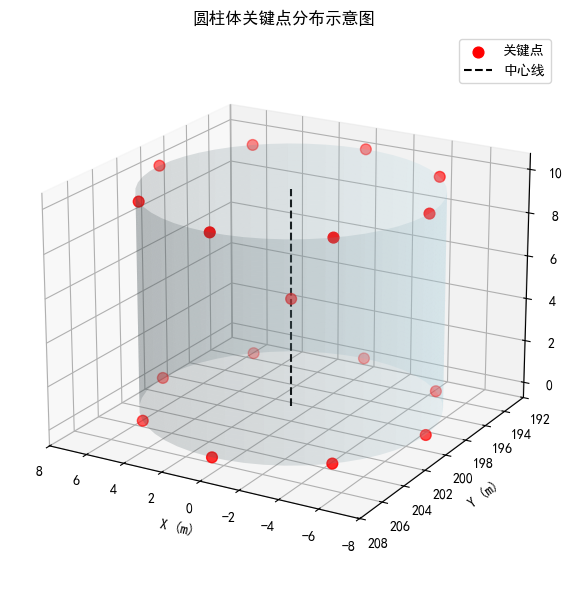

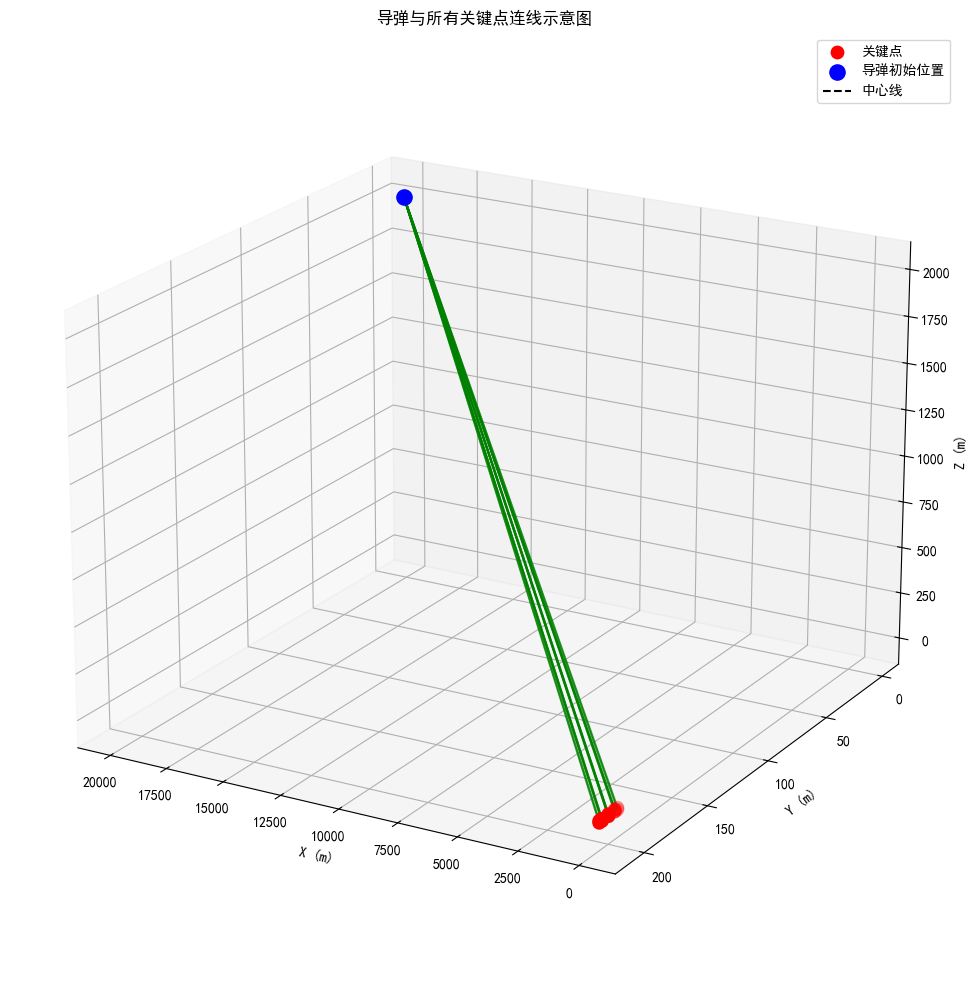

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
plt.rcParams['axes.unicode_minus'] = False   # 正确显示负号

# --- 1. 定义常量 (已根据题目核对) ---
# 导弹M1
V_M1 = 300  # 速度 (m/s)
P0_M1 = np.array([20000, 0, 2000])  # 初始位置 (m)
TARGET_FALSE = np.array([0, 0, 0])   # 假目标位置 (m)

# 无人机 FY1
P0_FY1 = np.array([17800, 0, 1800]) # 初始位置 (m)
V_FY1_MIN, V_FY1_MAX = 70, 140       # 速度范围 (m/s)

# 真目标 (圆柱体)
TARGET_TRUE_CENTER_BASE = np.array([0, 200, 0]) # 底面中心
TARGET_TRUE_RADIUS = 7    # 半径 (m)
TARGET_TRUE_HEIGHT = 10   # 高度 (m)

# 烟幕
SMOKE_CLOUD_RADIUS = 10   # 烟幕云半径 (m)
SMOKE_CLOUD_SINK_V = 3    # 烟幕云下沉速度 (m/s)
SMOKE_DURATION = 20       # 烟幕有效持续时间 (s)

# 物理常量
G = 9.8  # 重力加速度 (m/s^2)

# --- 2. 运动学模型 ---
direction_m1 = (TARGET_FALSE - P0_M1) / np.linalg.norm(TARGET_FALSE - P0_M1)
def missile_position(t):
    return P0_M1 + V_M1 * t * direction_m1

def uav_position(v_f, theta, t):
    vx = v_f * np.cos(theta)
    vy = v_f * np.sin(theta)
    return P0_FY1 + t * np.array([vx, vy, 0])

def grenade_position(v_f, theta, t_d, t):
    if t < t_d: return uav_position(v_f, theta, t)
    p0_grenade = uav_position(v_f, theta, t_d)
    v0_grenade = np.array([v_f * np.cos(theta), v_f * np.sin(theta), 0])
    dt = t - t_d
    pos = p0_grenade + v0_grenade * dt + 0.5 * np.array([0, 0, -G]) * dt**2
    return pos

def cloud_center_position(v_f, theta, t_d, t_b, t):
    if t < t_b: return None
    p_detonation = grenade_position(v_f, theta, t_d, t_b)
    dt = t - t_b
    return p_detonation + dt * np.array([0, 0, -SMOKE_CLOUD_SINK_V])

# --- 3. 几何遮蔽判断 ---
target_key_points = []
for h in [0, TARGET_TRUE_HEIGHT]:
    center = TARGET_TRUE_CENTER_BASE + np.array([0, 0, h])
    for angle in np.linspace(0, 2 * np.pi, 8, endpoint=False): # 增加关键点以提高精度
        target_key_points.append(center + np.array([TARGET_TRUE_RADIUS * np.cos(angle), TARGET_TRUE_RADIUS * np.sin(angle), 0]))
target_key_points.append(TARGET_TRUE_CENTER_BASE + np.array([0, 0, TARGET_TRUE_HEIGHT/2]))

def is_line_segment_intercepted_by_sphere(p1, p2, sphere_center, sphere_radius):
    v = p2 - p1
    a = np.dot(v, v)
    if a == 0: return False
    b = 2 * np.dot(v, p1 - sphere_center)
    c = np.dot(p1 - sphere_center, p1 - sphere_center) - sphere_radius**2
    discriminant = b**2 - 4*a*c
    if discriminant < 0: return False
    t1 = (-b - np.sqrt(discriminant)) / (2 * a)
    t2 = (-b + np.sqrt(discriminant)) / (2 * a)
    if (0 <= t1 <= 1) or (0 <= t2 <= 1) or (t1*t2 < 0): return True
    return False

def is_shielded(m_pos, c_pos):
    if c_pos is None: return False
    for point in target_key_points:
        if not is_line_segment_intercepted_by_sphere(m_pos, point, c_pos, SMOKE_CLOUD_RADIUS):
            return False
    return True

# --- 4. 适应度函数 ---
def calculate_fitness(params, return_shield_period=False):
    v_f, theta, t_d, t_b = params
    if t_d < 1.5 or t_b <= t_d: 
        if return_shield_period:
            return 0.0, None, None
        return 0.0
    total_shielding_time = 0
    time_step = 0.01 # 使用更小的时间步长以提高精度
    shielding_start = None
    shielding_end = None
    shielding = False
    t_shield_start = None
    t_shield_end = None
    for t in np.arange(t_b, t_b + SMOKE_DURATION, time_step):
        m_pos = missile_position(t)
        if m_pos[0] <= TARGET_TRUE_CENTER_BASE[0]: break
        c_pos = cloud_center_position(v_f, theta, t_d, t_b, t)
        if c_pos is not None and c_pos[2] < -SMOKE_CLOUD_RADIUS: break
        if is_shielded(m_pos, c_pos):
            total_shielding_time += time_step
            if not shielding:
                shielding = True
                t_shield_start = t
            t_shield_end = t
        else:
            if shielding:
                break  # 遮蔽结束
    if return_shield_period:
        return total_shielding_time, t_shield_start, t_shield_end
    return total_shielding_time

# --- 5. PSO 主算法 ---
def pso_optimizer(n_particles, n_iterations, initial_solution=None):
    bounds = [(V_FY1_MIN, V_FY1_MAX), (0, 2 * np.pi), (1.5, 40), (2, 50)]
    particles_pos = np.random.rand(n_particles, 4)
    for i in range(4):
        particles_pos[:, i] = particles_pos[:, i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    if initial_solution is not None:
        particles_pos[0] = initial_solution
    particles_vel = np.random.randn(n_particles, 4) * 0.1
    pbest_pos = np.copy(particles_pos)
    pbest_fitness = np.array([calculate_fitness(p) for p in pbest_pos])
    gbest_idx = np.argmax(pbest_fitness)
    gbest_pos = pbest_pos[gbest_idx]
    gbest_fitness = pbest_fitness[gbest_idx]
    w, c1, c2 = 0.9, 2.0, 2.0
    print("\n--- 开始优化 ---")
    start_time = time.time()
    for it in range(n_iterations):
        for i in range(n_particles):
            current_fitness = calculate_fitness(particles_pos[i])
            if current_fitness > pbest_fitness[i]:
                pbest_fitness[i] = current_fitness
                pbest_pos[i] = particles_pos[i]
                if current_fitness > gbest_fitness:
                    gbest_fitness = current_fitness
                    gbest_pos = particles_pos[i]
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            cognitive_vel = c1 * r1 * (pbest_pos[i] - particles_pos[i])
            social_vel = c2 * r2 * (gbest_pos - particles_pos[i])
            particles_vel[i] = w * particles_vel[i] + cognitive_vel + social_vel
            particles_pos[i] += particles_vel[i]
            for j in range(4):
                particles_pos[i, j] = np.clip(particles_pos[i, j], bounds[j][0], bounds[j][1])
        if (it + 1) % 10 == 0:
            print(f"迭代次数: {it + 1}/{n_iterations}, 当前最优遮蔽时间: {gbest_fitness:.3f} s")
    end_time = time.time()
    print(f"优化完成! 总耗时: {end_time - start_time:.2f} s")
    return gbest_pos, gbest_fitness

# --- 6. 执行与结果 ---
if __name__ == '__main__':
    # --- 第1步: 验证问题1的条件 ---
    print("--- 正在验证问题1的条件 ---")
    v_f_initial = 120.0
    t_d_initial = 1.5
    t_b_initial = 1.5 + 3.6
    direction_vector_xy = TARGET_FALSE[0:2] - P0_FY1[0:2]
    theta_initial = np.arctan2(direction_vector_xy[1], direction_vector_xy[0])
    initial_params = np.array([v_f_initial, theta_initial, t_d_initial, t_b_initial])
    shielding_time, t_shield_start, t_shield_end = calculate_fitness(initial_params, return_shield_period=True)

    # 计算烟雾弹投放位置
    grenade_drop_pos = uav_position(v_f_initial, theta_initial, t_d_initial)
    # 计算爆炸位置
    grenade_boom_pos = grenade_position(v_f_initial, theta_initial, t_d_initial, t_b_initial)
    # 计算无人机在爆炸时刻的位置
    uav_pos_at_boom = uav_position(v_f_initial, theta_initial, t_b_initial)
    # 计算导弹在爆炸时刻的位置
    missile_pos_at_boom = missile_position(t_b_initial)

    print(f"烟雾弹投放位置: {grenade_drop_pos}")
    print(f"烟雾弹投放时间: {t_d_initial:.3f} s")
    print(f"烟雾弹爆炸位置: {grenade_boom_pos}")
    print(f"烟雾弹爆炸时间: {t_b_initial:.3f} s")
    print(f"遮蔽时间: {shielding_time:.3f} s")
    print(f"无人机在爆炸时刻的位置: {uav_pos_at_boom}")
    print(f"导弹在爆炸时刻的位置: {missile_pos_at_boom}")

    if t_shield_start is not None and t_shield_end is not None:
        m_pos_start = missile_position(t_shield_start)
        c_pos_start = cloud_center_position(v_f_initial, theta_initial, t_d_initial, t_b_initial, t_shield_start)
        m_pos_end = missile_position(t_shield_end)
        c_pos_end = cloud_center_position(v_f_initial, theta_initial, t_d_initial, t_b_initial, t_shield_end)
        print(f"遮蔽时间段: [{t_shield_start:.3f} s, {t_shield_end:.3f} s]")
        print(f"遮蔽开始时导弹位置: {m_pos_start}")
        print(f"遮蔽开始时烟雾中心位置: {c_pos_start}")
        print(f"遮蔽结束时导弹位置: {m_pos_end}")
        print(f"遮蔽结束时烟雾中心位置: {c_pos_end}")
    else:
        print("未检测到有效遮蔽时间段。")

    # --------- 新增：画出圆柱体关键点 ---------
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # 画圆柱体表面（可选，仅辅助理解）
    z = np.linspace(0, TARGET_TRUE_HEIGHT, 50)
    theta_cyl = np.linspace(0, 2 * np.pi, 50)
    theta_cyl_grid, z_grid = np.meshgrid(theta_cyl, z)
    x_cyl = TARGET_TRUE_CENTER_BASE[0] + TARGET_TRUE_RADIUS * np.cos(theta_cyl_grid)
    y_cyl = TARGET_TRUE_CENTER_BASE[1] + TARGET_TRUE_RADIUS * np.sin(theta_cyl_grid)
    z_cyl = TARGET_TRUE_CENTER_BASE[2] + z_grid
    ax.plot_surface(x_cyl, y_cyl, z_cyl, color='lightblue', alpha=0.2, linewidth=0)

    # 画关键点
    key_points = np.array(target_key_points)
    ax.scatter(key_points[:,0], key_points[:,1], key_points[:,2], color='red', s=60, label='关键点')

    # 画圆柱体中心线
    ax.plot([TARGET_TRUE_CENTER_BASE[0], TARGET_TRUE_CENTER_BASE[0]],
            [TARGET_TRUE_CENTER_BASE[1], TARGET_TRUE_CENTER_BASE[1]],
            [0, TARGET_TRUE_HEIGHT], color='k', linestyle='--', label='中心线')

    # 设置坐标轴标签
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('圆柱体关键点分布示意图')
    ax.legend()
    ax.view_init(elev=20, azim=120)
    plt.tight_layout()
    plt.show()

    # --------- 新增：画大图，显示所有关键点和导弹连线 ---------
    # 选取导弹初始位置
    missile_start = P0_M1
    # 画大图
    fig2 = plt.figure(figsize=(14, 10))
    ax2 = fig2.add_subplot(111, projection='3d')

    # 画圆柱体表面
    ax2.plot_surface(x_cyl, y_cyl, z_cyl, color='lightblue', alpha=0.2, linewidth=0)

    # 画关键点
    ax2.scatter(key_points[:,0], key_points[:,1], key_points[:,2], color='red', s=80, label='关键点')

    # 画导弹初始位置
    ax2.scatter([missile_start[0]], [missile_start[1]], [missile_start[2]], color='blue', s=120, label='导弹初始位置')

    # 画导弹与每个关键点的连线
    for pt in key_points:
        ax2.plot([missile_start[0], pt[0]], [missile_start[1], pt[1]], [missile_start[2], pt[2]], color='green', alpha=0.7, linewidth=1.5)

    # 画圆柱体中心线
    ax2.plot([TARGET_TRUE_CENTER_BASE[0], TARGET_TRUE_CENTER_BASE[0]],
             [TARGET_TRUE_CENTER_BASE[1], TARGET_TRUE_CENTER_BASE[1]],
             [0, TARGET_TRUE_HEIGHT], color='k', linestyle='--', label='中心线')

    # 设置坐标轴标签
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_zlabel('Z (m)')
    ax2.set_title('导弹与所有关键点连线示意图')
    ax2.legend()
    ax2.view_init(elev=20, azim=120)
    plt.tight_layout()
    plt.show()


In [10]:
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
plt.rcParams['axes.unicode_minus'] = False   # 正确显示负号

# --- 1. 定义常量 (已根据题目核对) ---
# 导弹M1
V_M1 = 300  # 速度 (m/s)
P0_M1 = np.array([20000, 0, 2000])  # 初始位置 (m)
TARGET_FALSE = np.array([0, 0, 0])   # 假目标位置 (m)

# 无人机 FY1
P0_FY1 = np.array([17800, 0, 1800]) # 初始位置 (m)
V_FY1_MIN, V_FY1_MAX = 70, 140       # 速度范围 (m/s)

# 真目标 (圆柱体)
TARGET_TRUE_CENTER_BASE = np.array([0, 200, 0]) # 底面中心
TARGET_TRUE_RADIUS = 7    # 半径 (m)
TARGET_TRUE_HEIGHT = 10   # 高度 (m)

# 烟幕
SMOKE_CLOUD_RADIUS = 10   # 烟幕云半径 (m)
SMOKE_CLOUD_SINK_V = 3    # 烟幕云下沉速度 (m/s)
SMOKE_DURATION = 20       # 烟幕有效持续时间 (s)

# 物理常量
G = 9.8  # 重力加速度 (m/s^2)

# --- 2. 运动学模型 ---
direction_m1 = (TARGET_FALSE - P0_M1) / np.linalg.norm(TARGET_FALSE - P0_M1)
def missile_position(t):
    return P0_M1 + V_M1 * t * direction_m1

def uav_position(v_f, theta, t):
    vx = v_f * np.cos(theta)
    vy = v_f * np.sin(theta)
    return P0_FY1 + t * np.array([vx, vy, 0])

def grenade_position(v_f, theta, t_d, t):
    if t < t_d: return uav_position(v_f, theta, t)
    p0_grenade = uav_position(v_f, theta, t_d)
    v0_grenade = np.array([v_f * np.cos(theta), v_f * np.sin(theta), 0])
    dt = t - t_d
    pos = p0_grenade + v0_grenade * dt + 0.5 * np.array([0, 0, -G]) * dt**2
    return pos

def cloud_center_position(v_f, theta, t_d, t_b, t):
    if t < t_b: return None
    p_detonation = grenade_position(v_f, theta, t_d, t_b)
    dt = t - t_b
    return p_detonation + dt * np.array([0, 0, -SMOKE_CLOUD_SINK_V])

# --- 3. 几何遮蔽判断 ---
target_key_points = []
for h in [0, TARGET_TRUE_HEIGHT]:
    center = TARGET_TRUE_CENTER_BASE + np.array([0, 0, h])
    for angle in np.linspace(0, 2 * np.pi, 3, endpoint=False): # 增加关键点以提高精度
        target_key_points.append(center + np.array([TARGET_TRUE_RADIUS * np.cos(angle), TARGET_TRUE_RADIUS * np.sin(angle), 0]))
target_key_points.append(TARGET_TRUE_CENTER_BASE + np.array([0, 0, TARGET_TRUE_HEIGHT/2]))

def is_line_segment_intercepted_by_sphere(p1, p2, sphere_center, sphere_radius):
    v = p2 - p1
    a = np.dot(v, v)
    if a == 0: return False
    b = 2 * np.dot(v, p1 - sphere_center)
    c = np.dot(p1 - sphere_center, p1 - sphere_center) - sphere_radius**2
    discriminant = b**2 - 4*a*c
    if discriminant < 0: return False
    t1 = (-b - np.sqrt(discriminant)) / (2 * a)
    t2 = (-b + np.sqrt(discriminant)) / (2 * a)
    if (0 <= t1 <= 1) or (0 <= t2 <= 1) or (t1*t2 < 0): return True
    return False

def is_shielded(m_pos, c_pos):
    if c_pos is None: return False
    for point in target_key_points:
        if not is_line_segment_intercepted_by_sphere(m_pos, point, c_pos, SMOKE_CLOUD_RADIUS):
            return False
    return True

# --- 4. 适应度函数 ---
def calculate_fitness(params, return_shield_period=False):
    v_f, theta, t_d, t_b = params
    if t_d < 1.5 or t_b <= t_d: 
        if return_shield_period:
            return 0.0, None, None
        return 0.0
    total_shielding_time = 0
    time_step = 0.01 # 使用更小的时间步长以提高精度
    shielding_start = None
    shielding_end = None
    shielding = False
    t_shield_start = None
    t_shield_end = None
    for t in np.arange(t_b, t_b + SMOKE_DURATION, time_step):
        m_pos = missile_position(t)
        if m_pos[0] <= TARGET_TRUE_CENTER_BASE[0]: break
        c_pos = cloud_center_position(v_f, theta, t_d, t_b, t)
        if c_pos is not None and c_pos[2] < -SMOKE_CLOUD_RADIUS: break
        if is_shielded(m_pos, c_pos):
            total_shielding_time += time_step
            if not shielding:
                shielding = True
                t_shield_start = t
            t_shield_end = t
        else:
            if shielding:
                break  # 遮蔽结束
    if return_shield_period:
        return total_shielding_time, t_shield_start, t_shield_end
    return total_shielding_time

# --- 5. PSO 主算法 ---
def pso_optimizer(n_particles, n_iterations, initial_solution=None):
    bounds = [(V_FY1_MIN, V_FY1_MAX), (0, 2 * np.pi), (1.5, 40), (2, 50)]
    particles_pos = np.random.rand(n_particles, 4)
    for i in range(4):
        particles_pos[:, i] = particles_pos[:, i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    if initial_solution is not None:
        particles_pos[0] = initial_solution
    particles_vel = np.random.randn(n_particles, 4) * 0.1
    pbest_pos = np.copy(particles_pos)
    pbest_fitness = np.array([calculate_fitness(p) for p in pbest_pos])
    gbest_idx = np.argmax(pbest_fitness)
    gbest_pos = pbest_pos[gbest_idx]
    gbest_fitness = pbest_fitness[gbest_idx]
    w, c1, c2 = 0.9, 2.0, 2.0
    print("\n--- 开始优化 ---")
    start_time = time.time()
    for it in range(n_iterations):
        for i in range(n_particles):
            current_fitness = calculate_fitness(particles_pos[i])
            if current_fitness > pbest_fitness[i]:
                pbest_fitness[i] = current_fitness
                pbest_pos[i] = particles_pos[i]
                if current_fitness > gbest_fitness:
                    gbest_fitness = current_fitness
                    gbest_pos = particles_pos[i]
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            cognitive_vel = c1 * r1 * (pbest_pos[i] - particles_pos[i])
            social_vel = c2 * r2 * (gbest_pos - particles_pos[i])
            particles_vel[i] = w * particles_vel[i] + cognitive_vel + social_vel
            particles_pos[i] += particles_vel[i]
            for j in range(4):
                particles_pos[i, j] = np.clip(particles_pos[i, j], bounds[j][0], bounds[j][1])
        if (it + 1) % 10 == 0:
            print(f"迭代次数: {it + 1}/{n_iterations}, 当前最优遮蔽时间: {gbest_fitness:.3f} s")
    end_time = time.time()
    print(f"优化完成! 总耗时: {end_time - start_time:.2f} s")
    return gbest_pos, gbest_fitness

# --- 6. 执行与结果 ---
if __name__ == '__main__':
    # --- 第1步: 验证问题1的条件 ---
    print("--- 正在验证问题1的条件 ---")
    v_f_initial = 120.0
    t_d_initial = 1.5
    t_b_initial = 1.5 + 3.6
    direction_vector_xy = TARGET_FALSE[0:2] - P0_FY1[0:2]
    theta_initial = np.arctan2(direction_vector_xy[1], direction_vector_xy[0])
    initial_params = np.array([v_f_initial, theta_initial, t_d_initial, t_b_initial])
    shielding_time, t_shield_start, t_shield_end = calculate_fitness(initial_params, return_shield_period=True)

    # 计算烟雾弹投放位置
    grenade_drop_pos = uav_position(v_f_initial, theta_initial, t_d_initial)
    # 计算爆炸位置
    grenade_boom_pos = grenade_position(v_f_initial, theta_initial, t_d_initial, t_b_initial)
    # 计算无人机在爆炸时刻的位置
    uav_pos_at_boom = uav_position(v_f_initial, theta_initial, t_b_initial)
    # 计算导弹在爆炸时刻的位置
    missile_pos_at_boom = missile_position(t_b_initial)

    print(f"烟雾弹投放位置: {grenade_drop_pos}")
    print(f"烟雾弹投放时间: {t_d_initial:.3f} s")
    print(f"烟雾弹爆炸位置: {grenade_boom_pos}")
    print(f"烟雾弹爆炸时间: {t_b_initial:.3f} s")
    print(f"遮蔽时间: {shielding_time:.3f} s")
    print(f"无人机在爆炸时刻的位置: {uav_pos_at_boom}")
    print(f"导弹在爆炸时刻的位置: {missile_pos_at_boom}")

    if t_shield_start is not None and t_shield_end is not None:
        m_pos_start = missile_position(t_shield_start)
        c_pos_start = cloud_center_position(v_f_initial, theta_initial, t_d_initial, t_b_initial, t_shield_start)
        m_pos_end = missile_position(t_shield_end)
        c_pos_end = cloud_center_position(v_f_initial, theta_initial, t_d_initial, t_b_initial, t_shield_end)
        print(f"遮蔽时间段: [{t_shield_start:.3f} s, {t_shield_end:.3f} s]")
        print(f"遮蔽开始时导弹位置: {m_pos_start}")
        print(f"遮蔽开始时烟雾中心位置: {c_pos_start}")
        print(f"遮蔽结束时导弹位置: {m_pos_end}")
        print(f"遮蔽结束时烟雾中心位置: {c_pos_end}")
    else:
        print("未检测到有效遮蔽时间段。")

--- 正在验证问题1的条件 ---
烟雾弹投放位置: [1.76200000e+04 2.20436424e-14 1.80000000e+03]
烟雾弹投放时间: 1.500 s
烟雾弹爆炸位置: [1.71880000e+04 7.49483841e-14 1.73649600e+03]
烟雾弹爆炸时间: 5.100 s
遮蔽时间: 1.390 s
无人机在爆炸时刻的位置: [1.71880000e+04 7.49483841e-14 1.80000000e+03]
导弹在爆炸时刻的位置: [18477.59309898     0.          1847.7593099 ]
遮蔽时间段: [8.060 s, 9.440 s]
遮蔽开始时导弹位置: [17594.00007407     0.          1759.40000741]
遮蔽开始时烟雾中心位置: [1.71880000e+04 7.49483841e-14 1.72761600e+03]
遮蔽结束时导弹位置: [17182.05467733     0.          1718.20546773]
遮蔽结束时烟雾中心位置: [1.71880000e+04 7.49483841e-14 1.72347600e+03]


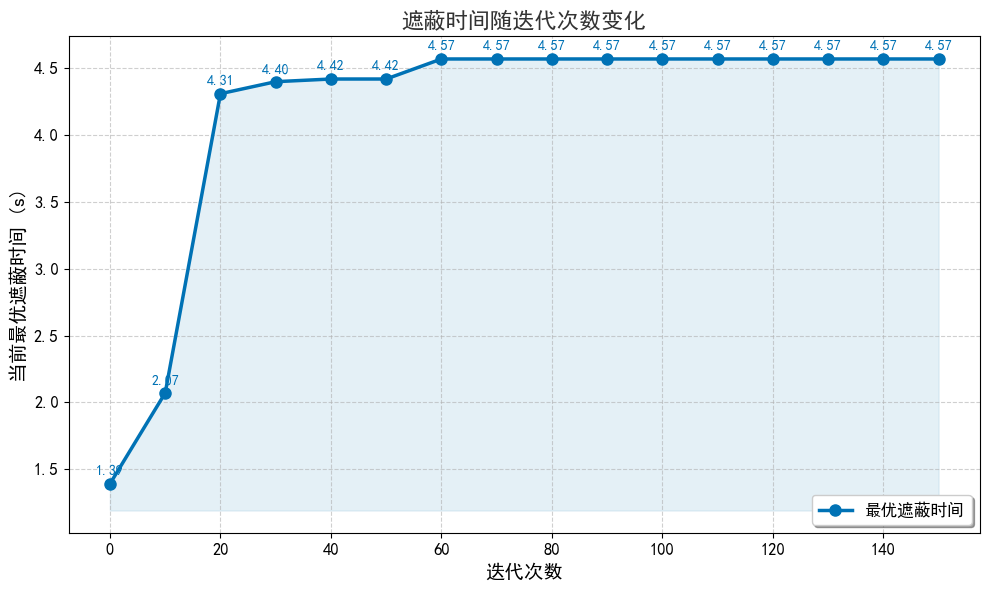

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
plt.rcParams['axes.unicode_minus'] = False   # 正确显示负号

# 假设有如下迭代数据（可根据实际数据替换）
iterations = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
shield_times = [1.390,2.070, 4.310, 4.400, 4.420, 4.420, 4.570, 4.570, 4.570, 4.570, 4.570, 4.570, 4.570, 4.570, 4.570, 4.570]

plt.figure(figsize=(10, 6))
# 使用更粗的线条和更大的点
plt.plot(iterations, shield_times, marker='o', markersize=8, linestyle='-', linewidth=2.5, color='#0072B5', label='最优遮蔽时间')
# 填充曲线下方区域
plt.fill_between(iterations, shield_times, min(shield_times)-0.2, color='#A6CEE3', alpha=0.3)

plt.xlabel('迭代次数', fontsize=14, fontweight='bold')
plt.ylabel('当前最优遮蔽时间 (s)', fontsize=14, fontweight='bold')
plt.title('遮蔽时间随迭代次数变化', fontsize=16, fontweight='bold', color='#333333')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right', frameon=True, fancybox=True, shadow=True)
# 添加数据标签
for x, y in zip(iterations, shield_times):
    plt.text(x, y+0.05, f"{y:.2f}", ha='center', va='bottom', fontsize=10, color='#0072B5')

plt.tight_layout()
plt.show()

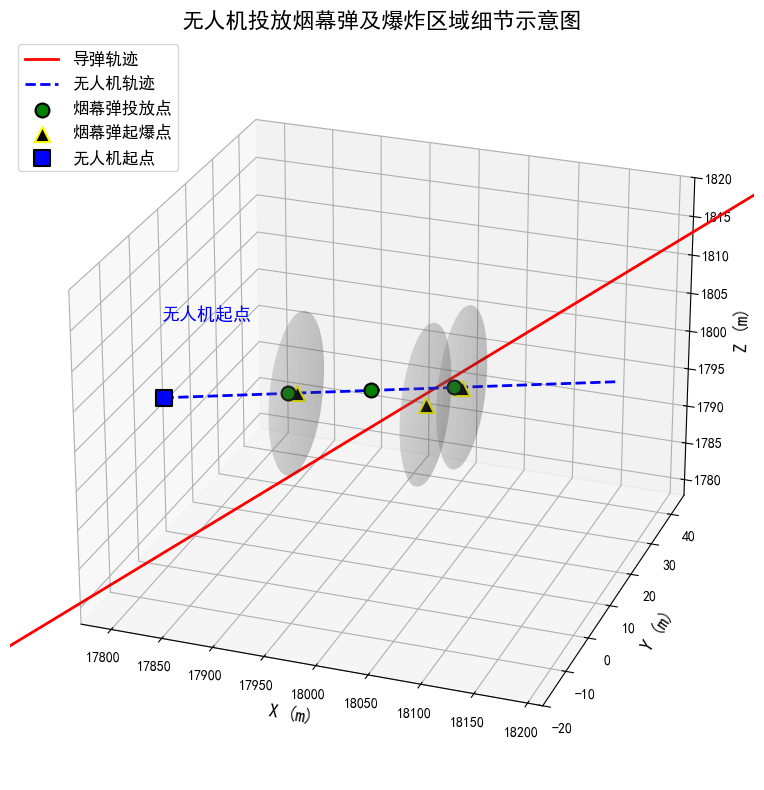

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
plt.rcParams['axes.unicode_minus'] = False   # 正确显示负号

# --- 1. 定义常量 (与原始一致) ---
V_M1 = 300  # 导弹速度 (m/s)
P0_M1 = np.array([20000, 0, 2000])  # 导弹初始位置
TARGET_FALSE = np.array([0, 0, 0])   # 假目标位置

P0_FY1 = np.array([17800, 0, 1800]) # 无人机初始位置

# 真目标 (圆柱体)
TARGET_TRUE_CENTER_BASE = np.array([0, 200, 0]) # 底面中心
TARGET_TRUE_RADIUS = 7    # 半径 (m)
TARGET_TRUE_HEIGHT = 10   # 高度 (m)

# 烟幕
SMOKE_CLOUD_RADIUS = 10   # 烟幕云半径 (m)
G = 9.8  # 重力加速度 (m/s^2)

# --- 2. 运动学模型 ---
direction_m1 = (TARGET_FALSE - P0_M1) / np.linalg.norm(TARGET_FALSE - P0_M1)
def missile_position(t):
    return P0_M1 + V_M1 * t * direction_m1

def uav_position(v_f, theta, t):
    vx = v_f * np.cos(theta)
    vy = v_f * np.sin(theta)
    return P0_FY1 + t * np.array([vx, vy, 0])

def grenade_position(v_f, theta, t_d, t):
    if t < t_d: return uav_position(v_f, theta, t)
    p0_grenade = uav_position(v_f, theta, t_d)
    v0_grenade = np.array([v_f * np.cos(theta), v_f * np.sin(theta), 0])
    dt = t - t_d
    pos = p0_grenade + v0_grenade * dt + 0.5 * np.array([0, 0, -G]) * dt**2
    return pos

# --- 3. 示例参数（可根据实际最优解替换） ---
v_f = 70.0
theta = np.deg2rad(3.97)
t_d1, t_b1 = 1.5, 1.6
t_d2, t_b2 = 2.5, 3.16
t_d3, t_b3 = 3.5, 3.6

# --- 4. 计算轨迹点 ---
t_missile = np.linspace(0, 70, 300)
missile_traj = np.array([missile_position(t) for t in t_missile])

t_uav = np.linspace(0, t_d3+2, 100)
uav_traj = np.array([uav_position(v_f, theta, t) for t in t_uav])

drop_points = [
    uav_position(v_f, theta, t_d1),
    uav_position(v_f, theta, t_d2),
    uav_position(v_f, theta, t_d3)
]
detonation_points = [
    grenade_position(v_f, theta, t_d1, t_b1),
    grenade_position(v_f, theta, t_d2, t_b2),
    grenade_position(v_f, theta, t_d3, t_b3)
]

# --- 5. 绘制烟幕云球体 ---
def plot_sphere(ax, center, radius, color='gray', alpha=0.3):
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color=color, alpha=alpha, linewidth=0)

# --- 6. 绘图 ---
fig = plt.figure(figsize=(10, 8))  # 调整比例，更协调
ax = fig.add_subplot(111, projection='3d')

# 画导弹轨迹
ax.plot(missile_traj[:,0], missile_traj[:,1], missile_traj[:,2], 'r-', label='导弹轨迹', linewidth=2, zorder=1)

# 画无人机轨迹
ax.plot(uav_traj[:,0], uav_traj[:,1], uav_traj[:,2], 'b--', label='无人机轨迹', linewidth=2, zorder=2)

# 显示烟幕弹投放点
for i, pt in enumerate(drop_points):
    ax.scatter(pt[0], pt[1], pt[2], c='g', marker='o', s=100, label='烟幕弹投放点' if i==0 else None, edgecolors='black', linewidths=1.5, zorder=5)
    #ax.text(pt[0], pt[1], pt[2]+10, f'投放{i+1}', color='g', fontsize=13, weight='bold', zorder=10)

# 画烟幕弹起爆点和烟幕云
for i, pt in enumerate(detonation_points):
    ax.scatter(pt[0], pt[1], pt[2], c='k', marker='^', s=120, label='烟幕弹起爆点' if i==0 else None, edgecolors='yellow', linewidths=1.5, zorder=6)
    #ax.text(pt[0], pt[1], pt[2]+10, f'起爆{i+1}', color='k', fontsize=13, weight='bold', zorder=10)
    plot_sphere(ax, pt, SMOKE_CLOUD_RADIUS, color='gray', alpha=0.15)

# 不显示导弹初始点
# ax.scatter(P0_M1[0], P0_M1[1], P0_M1[2], c='r', marker='x', s=150, label='导弹初始点', linewidths=3, zorder=8)
# ax.text(P0_M1[0], P0_M1[1], P0_M1[2]+10, '导弹起点', color='r', fontsize=13, weight='bold', zorder=10)

# 画无人机初始点
ax.scatter(P0_FY1[0], P0_FY1[1], P0_FY1[2], c='b', marker='s', s=120, label='无人机起点', edgecolors='black', linewidths=1.5, zorder=9)
ax.text(P0_FY1[0], P0_FY1[1], P0_FY1[2]+10, '无人机起点', color='b', fontsize=13, weight='bold', zorder=10)

# ================== 修正坐标系显示 ==================
# 只显示无人机、投弹和爆炸相关区域，集中显示细节
# 自动根据投放点和爆炸点范围设置坐标轴范围
all_x = np.concatenate([uav_traj[:,0], np.array(drop_points)[:,0], np.array(detonation_points)[:,0]])
all_y = np.concatenate([uav_traj[:,1], np.array(drop_points)[:,1], np.array(detonation_points)[:,1]])
all_z = np.concatenate([uav_traj[:,2], np.array(drop_points)[:,2], np.array(detonation_points)[:,2]])

# 计算边界并适当扩展
margin_x = 30
margin_y = 20
margin_z = 20
x_min, x_max = all_x.min()-margin_x, all_x.max()+margin_x
y_min, y_max = all_y.min()-margin_y, all_y.max()+margin_y
z_min, z_max = all_z.min()-margin_z, all_z.max()+margin_z

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

ax.set_xlabel('X (m)', fontsize=13)
ax.set_ylabel('Y (m)', fontsize=13)
ax.set_zlabel('Z (m)', fontsize=13)
ax.set_title('无人机投放烟幕弹及爆炸区域细节示意图', fontsize=16, weight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.view_init(elev=25, azim=-70)
plt.tight_layout()
plt.show()

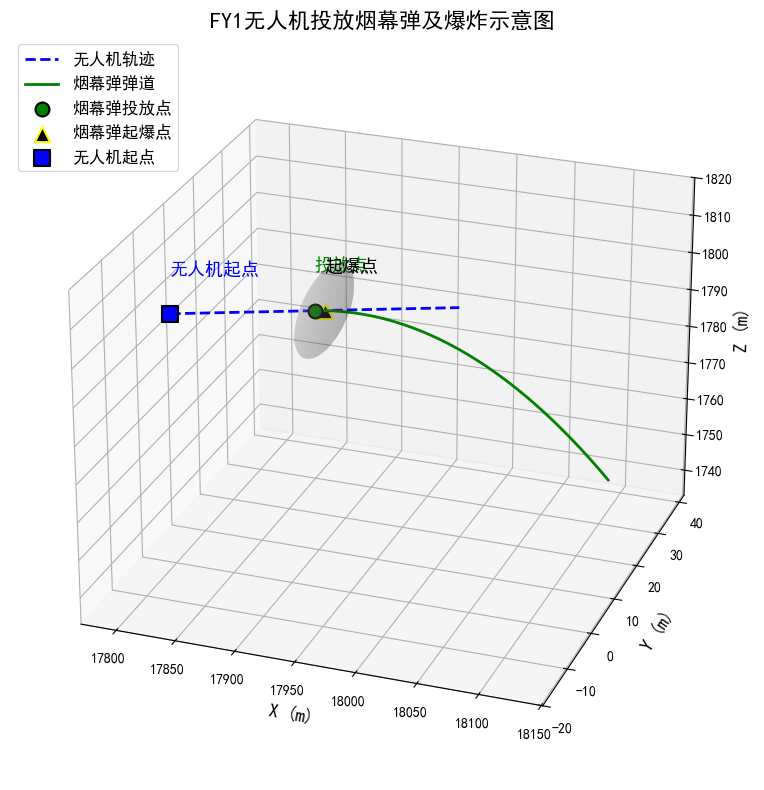

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
plt.rcParams['axes.unicode_minus'] = False   # 正确显示负号

# ================== 1. 读取FY1参数 ==================
# 这些参数来自 try.py 的 FY1 结果
v_f = 70.00  # 无人机飞行速度 (m/s)
theta = np.deg2rad(3.97)  # 飞行方向 (弧度)
t_d = 1.500   # 投放时间 (s)
t_b = 1.600   # 起爆时间 (s)
P0_FY1 = np.array([17800, 0, 1800])  # 无人机初始点

# 烟幕参数
SMOKE_CLOUD_RADIUS = 10
G = 9.8

# 投放点、起爆点
def uav_position(v_f, theta, t):
    vx = v_f * np.cos(theta)
    vy = v_f * np.sin(theta)
    return P0_FY1 + t * np.array([vx, vy, 0])

def grenade_position(v_f, theta, t_d, t):
    if t < t_d: return uav_position(v_f, theta, t)
    p0_grenade = uav_position(v_f, theta, t_d)
    v0_grenade = np.array([v_f * np.cos(theta), v_f * np.sin(theta), 0])
    dt = t - t_d
    pos = p0_grenade + v0_grenade * dt + 0.5 * np.array([0, 0, -G]) * dt**2
    return pos

drop_point = uav_position(v_f, theta, t_d)
detonation_point = grenade_position(v_f, theta, t_d, t_b)

# ================== 2. 轨迹计算 ==================
t_uav = np.linspace(0, t_d+1.5, 100)
uav_traj = np.array([uav_position(v_f, theta, t) for t in t_uav])

t_grenade = np.linspace(t_d, t_b+3, 60)
grenade_traj = np.array([grenade_position(v_f, theta, t_d, t) for t in t_grenade])

# ================== 3. 绘图 ==================
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 画无人机轨迹
ax.plot(uav_traj[:,0], uav_traj[:,1], uav_traj[:,2], 'b--', label='无人机轨迹', linewidth=2, zorder=2)

# 画烟幕弹弹道
ax.plot(grenade_traj[:,0], grenade_traj[:,1], grenade_traj[:,2], 'g-', label='烟幕弹弹道', linewidth=2, zorder=3)

# 投放点
ax.scatter(drop_point[0], drop_point[1], drop_point[2], c='g', marker='o', s=100, label='烟幕弹投放点', edgecolors='black', linewidths=1.5, zorder=5)
ax.text(drop_point[0], drop_point[1], drop_point[2]+10, '投放点', color='g', fontsize=13, weight='bold', zorder=10)

# 起爆点
ax.scatter(detonation_point[0], detonation_point[1], detonation_point[2], c='k', marker='^', s=120, label='烟幕弹起爆点', edgecolors='yellow', linewidths=1.5, zorder=6)
ax.text(detonation_point[0], detonation_point[1], detonation_point[2]+10, '起爆点', color='k', fontsize=13, weight='bold', zorder=10)

# 绘制烟幕云球体
def plot_sphere(ax, center, radius, color='gray', alpha=0.15):
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color=color, alpha=alpha, linewidth=0)

plot_sphere(ax, detonation_point, SMOKE_CLOUD_RADIUS, color='gray', alpha=0.18)

# 无人机起点
ax.scatter(P0_FY1[0], P0_FY1[1], P0_FY1[2], c='b', marker='s', s=120, label='无人机起点', edgecolors='black', linewidths=1.5, zorder=9)
ax.text(P0_FY1[0], P0_FY1[1], P0_FY1[2]+10, '无人机起点', color='b', fontsize=13, weight='bold', zorder=10)

# ================== 4. 坐标轴范围 ==================
all_x = np.concatenate([uav_traj[:,0], grenade_traj[:,0], [drop_point[0], detonation_point[0], P0_FY1[0]]])
all_y = np.concatenate([uav_traj[:,1], grenade_traj[:,1], [drop_point[1], detonation_point[1], P0_FY1[1]]])
all_z = np.concatenate([uav_traj[:,2], grenade_traj[:,2], [drop_point[2], detonation_point[2], P0_FY1[2]]])

margin_x = 30
margin_y = 20
margin_z = 20
x_min, x_max = all_x.min()-margin_x, all_x.max()+margin_x
y_min, y_max = all_y.min()-margin_y, all_y.max()+margin_y
z_min, z_max = all_z.min()-margin_z, all_z.max()+margin_z

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

ax.set_xlabel('X (m)', fontsize=13)
ax.set_ylabel('Y (m)', fontsize=13)
ax.set_zlabel('Z (m)', fontsize=13)
ax.set_title('FY1无人机投放烟幕弹及爆炸示意图', fontsize=16, weight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.view_init(elev=25, azim=-70)
plt.tight_layout()
plt.show()